<a href="https://colab.research.google.com/github/aakriti-jaluria/Google-Image-Downloader/blob/main/Aakriti_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install numpy pandas matplotlib seaborn scikit-learn xlsxwriter

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from google.colab import files

# Configuration dictionary for preprocessing, clustering, and evaluation
CONFIG = {
    'preprocessing_techniques': [
        'none',            # No preprocessing
        'normalization',   # Normalize data to range [0, 1]
        'standardization', # Standardize to zero mean and unit variance
        'pca',             # Dimensionality reduction using PCA
        'stand_norm',      # Standardization followed by normalization
        'stand_pca'        # Standardization followed by PCA
    ],
    'n_clusters_list': [3, 4, 5],  # Different numbers of clusters to test
    'metrics': [
        'Silhouette',      # Evaluate using Silhouette Score
        'Calinski-Harabasz', # Evaluate using Calinski-Harabasz Index
        'Davies-Bouldin'   # Evaluate using Davies-Bouldin Score
    ],
    'algorithms': [
        'K-Means',         # K-Means Clustering
        'Hierarchical',    # Hierarchical Clustering
        'Mean Shift'       # Mean Shift Clustering
    ]
}


assert isinstance(CONFIG['preprocessing_techniques'], list), "Preprocessing techniques must be a list."
assert isinstance(CONFIG['n_clusters_list'], list), "Cluster counts must be a list."
assert isinstance(CONFIG['metrics'], list), "Metrics must be a list."
assert isinstance(CONFIG['algorithms'], list), "Algorithms must be a list."

print("Configuration setup is complete and ready for clustering tasks!")


Configuration setup is complete and ready for clustering tasks!


In [34]:
def apply_preprocessing(X, technique):
    if technique == 'none':
        return X.copy()
    elif technique == 'normalization':
        return normalize(X)
    elif technique == 'standardization':
        return StandardScaler().fit_transform(X)
    elif technique == 'pca':
        return PCA(n_components=min(X.shape[1], 2)).fit_transform(X)
    elif technique == 'stand_norm':
        X_scaled = StandardScaler().fit_transform(X)
        return normalize(X_scaled)
    elif technique == 'stand_pca':
        X_scaled = StandardScaler().fit_transform(X)
        return PCA(n_components=min(X.shape[1], 2)).fit_transform(X_scaled)
    else:
        raise ValueError(f"Unknown preprocessing technique: {technique}")

def evaluate_clustering(X, labels):
    try:
        unique_labels = np.unique(labels)
        if len(unique_labels) < 2:
            return np.nan, np.nan, np.nan
        silhouette = silhouette_score(X, labels)
        calinski = calinski_harabasz_score(X, labels)
        davies = davies_bouldin_score(X, labels)
        return silhouette, calinski, davies
    except Exception as e:
        print(f"Error during clustering evaluation: {e}")
        return np.nan, np.nan, np.nan

def perform_meanshift_clustering(X):
    try:
        bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=min(500, X.shape[0]))
        if bandwidth <= 0:
            bandwidth = np.mean(np.linalg.norm(X - np.mean(X, axis=0), axis=1))
        meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        labels = meanshift.fit_predict(X)
        return evaluate_clustering(X, labels)
    except Exception as e:
        print(f"Error during Mean Shift clustering: {e}")
        return np.nan, np.nan, np.nan


In [35]:
def perform_clustering_analysis(X):
    results = []

    for prep_technique in CONFIG['preprocessing_techniques']:
        X_processed = apply_preprocessing(X, prep_technique)

        for n_clusters in CONFIG['n_clusters_list']:
            # K-Means
            try:
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                kmeans_labels = kmeans.fit_predict(X_processed)
                kmeans_scores = evaluate_clustering(X_processed, kmeans_labels)
            except Exception as e:
                print(f"K-Means error with {prep_technique}, {n_clusters} clusters: {e}")
                kmeans_scores = (np.nan, np.nan, np.nan)

            # Hierarchical
            try:
                hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
                hierarchical_labels = hierarchical.fit_predict(X_processed)
                hierarchical_scores = evaluate_clustering(X_processed, hierarchical_labels)
            except Exception as e:
                print(f"Hierarchical error with {prep_technique}, {n_clusters} clusters: {e}")
                hierarchical_scores = (np.nan, np.nan, np.nan)

            # Store results
            for algo, scores in [('K-Means', kmeans_scores), ('Hierarchical', hierarchical_scores)]:
                results.append({
                    'Preprocessing': prep_technique,
                    'n_clusters': n_clusters,
                    'Algorithm': algo,
                    'Silhouette': scores[0],
                    'Calinski-Harabasz': scores[1],
                    'Davies-Bouldin': scores[2]
                })

        # Mean Shift
        try:
            meanshift_scores = perform_meanshift_clustering(X_processed)
            results.append({
                'Preprocessing': prep_technique,
                'n_clusters': 'auto',
                'Algorithm': 'Mean Shift',
                'Silhouette': meanshift_scores[0],
                'Calinski-Harabasz': meanshift_scores[1],
                'Davies-Bouldin': meanshift_scores[2]
            })
        except Exception as e:
            print(f"Mean Shift error with {prep_technique}: {e}")

    return pd.DataFrame(results)


def format_results_table(results_df):
    formatted_tables = []

    prep_mapping = {
        'none': 'No Data Processing',
        'normalization': 'Using Normalization',
        'standardization': 'Using Transform',
        'pca': 'Using PCA',
        'stand_norm': 'Using T+N',
        'stand_pca': 'T+N+PCA'
    }

    for algorithm in CONFIG['algorithms']:
        algo_results = results_df[results_df['Algorithm'] == algorithm].copy()

        columns = pd.MultiIndex.from_product(
            [list(prep_mapping.values()), [f'c={c}' for c in CONFIG['n_clusters_list']]]
        )

        formatted_table = pd.DataFrame(index=CONFIG['metrics'], columns=columns)

        for prep_key, prep_name in prep_mapping.items():
            prep_results = algo_results[algo_results['Preprocessing'] == prep_key]

            for n_cluster in CONFIG['n_clusters_list']:
                cluster_results = prep_results[prep_results['n_clusters'] == n_cluster]

                if not cluster_results.empty:
                    for metric in CONFIG['metrics']:
                        value = cluster_results[metric].iloc[0]
                        formatted_table.loc[metric, (prep_name, f'c={n_cluster}')] = (
                            'NA' if pd.isna(value) else f'{value:.3f}'
                        )

        formatted_tables.append((algorithm, formatted_table))

    return formatted_tables


In [36]:
def save_and_visualize_results(formatted_tables):
    """Save clustering results to Excel and visualize them."""
    excel_filename = 'clustering_results_v2.xlsx'
    plot_filename = 'clustering_comparison_v2.png'

    # Save results to Excel
    with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
        workbook = writer.book

        header_format = workbook.add_format({
            'bold': True,
            'text_wrap': True,
            'valign': 'top',
            'border': 1
        })

        cell_format = workbook.add_format({
            'text_wrap': True,
            'border': 1
        })

        for algorithm, table in formatted_tables:
            sheet_name = algorithm.replace(' ', '_')[:31]  # Excel sheet names must be <= 31 characters
            table.to_excel(writer, sheet_name=sheet_name)

            worksheet = writer.sheets[sheet_name]

            # Add formatted headers
            for col_num, (prep, cluster) in enumerate(table.columns):
                worksheet.write(0, col_num + 1, prep, header_format)
                worksheet.write(1, col_num + 1, cluster, header_format)

            # Adjust column widths
            worksheet.set_column(0, 0, 20)
            worksheet.set_column(1, len(table.columns), 15)

    # Visualize results using matplotlib
    fig, axes = plt.subplots(len(formatted_tables), 1, figsize=(15, len(formatted_tables) * 5))
    fig.suptitle(
        'Performance Using Different Clustering Techniques on Various Parameters',
        y=0.95,
        fontsize=14
    )

    # Ensure axes is iterable, even with one plot
    if len(formatted_tables) == 1:
        axes = [axes]

    for idx, (algorithm, table) in enumerate(formatted_tables):
        ax = axes[idx]
        ax.axis('tight')
        ax.axis('off')

        # Create and format the table
        table_obj = ax.table(
            cellText=table.values,
            rowLabels=table.index,
            colLabels=[f'{prep}\n{cluster}' for prep, cluster in table.columns],
            cellLoc='center',
            loc='center'
        )

        table_obj.auto_set_font_size(False)
        table_obj.set_fontsize(9)
        table_obj.scale(1.2, 1.5)
        ax.set_title(f'Using {algorithm}\n ', pad=20)

    plt.tight_layout()
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

    # Download the plot and show it
    files.download(plot_filename)
    plt.show()


In [49]:
def save_and_visualize_results(formatted_tables):
    """Save clustering results to Excel and visualize them with enhanced table styling."""
    excel_filename = 'clustering_results_v2.xlsx'
    plot_filename = 'clustering_comparison_v2.png'

    # Save results to Excel
    with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
        workbook = writer.book

        header_format = workbook.add_format({
            'bold': True,
            'text_wrap': True,
            'valign': 'top',
            'border': 1,
            'bg_color': '#DDEBF7'  # Light blue background
        })

        cell_format = workbook.add_format({
            'text_wrap': True,
            'border': 1
        })

        for algorithm, table in formatted_tables:
            sheet_name = algorithm.replace(' ', '_')[:31]  # Excel sheet names must be <= 31 characters
            table.to_excel(writer, sheet_name=sheet_name)

            worksheet = writer.sheets[sheet_name]

            # Add formatted headers
            for col_num, (prep, cluster) in enumerate(table.columns):
                worksheet.write(0, col_num + 1, prep, header_format)
                worksheet.write(1, col_num + 1, cluster, header_format)

            # Adjust column widths
            worksheet.set_column(0, 0, 20)
            worksheet.set_column(1, len(table.columns), 15)

    # Enhanced Matplotlib visualization
    fig, axes = plt.subplots(len(formatted_tables), 1, figsize=(15, len(formatted_tables) * 6))
    fig.suptitle(
        'Performance Using Different Clustering Techniques on Various Parameters',
        y=0.95,
        fontsize=14
    )

    # Ensure axes is iterable, even with one plot
    if len(formatted_tables) == 1:
        axes = [axes]

    for idx, (algorithm, table) in enumerate(formatted_tables):
        ax = axes[idx]
        ax.axis('tight')
        ax.axis('off')

        # Create the table with enhanced style
        table_obj = ax.table(
            cellText=table.values,
            rowLabels=table.index,
            colLabels=[f'{prep}\n{cluster}' for prep, cluster in table.columns],
            cellLoc='center',
            loc='center'
        )

        # Apply styling
        table_obj.auto_set_font_size(False)
        table_obj.set_fontsize(10)
        table_obj.scale(1.2, 1.6)

        for key, cell in table_obj.get_celld().items():
            row, col = key
            if row == 0 or row == 1:  # Header cells
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor('#4F81BD')  # Dark blue for headers
            elif col == -1:  # Row labels
                cell.set_text_props(weight='bold')
                cell.set_facecolor('#DDEBF7')  # Light blue for row labels
            else:  # Data cells
                cell.set_facecolor('#F7F7F7')  # Light gray background
                cell.set_edgecolor('#BBBBBB')  # Light gray border

        ax.set_title(f'Using {algorithm}\n ', pad=20)

    plt.tight_layout()
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

    # Download the plot and show it
    files.download(plot_filename)
    plt.show()


Loading Iris dataset...
Performing clustering analysis...
Formatting results...
Saving and visualizing results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

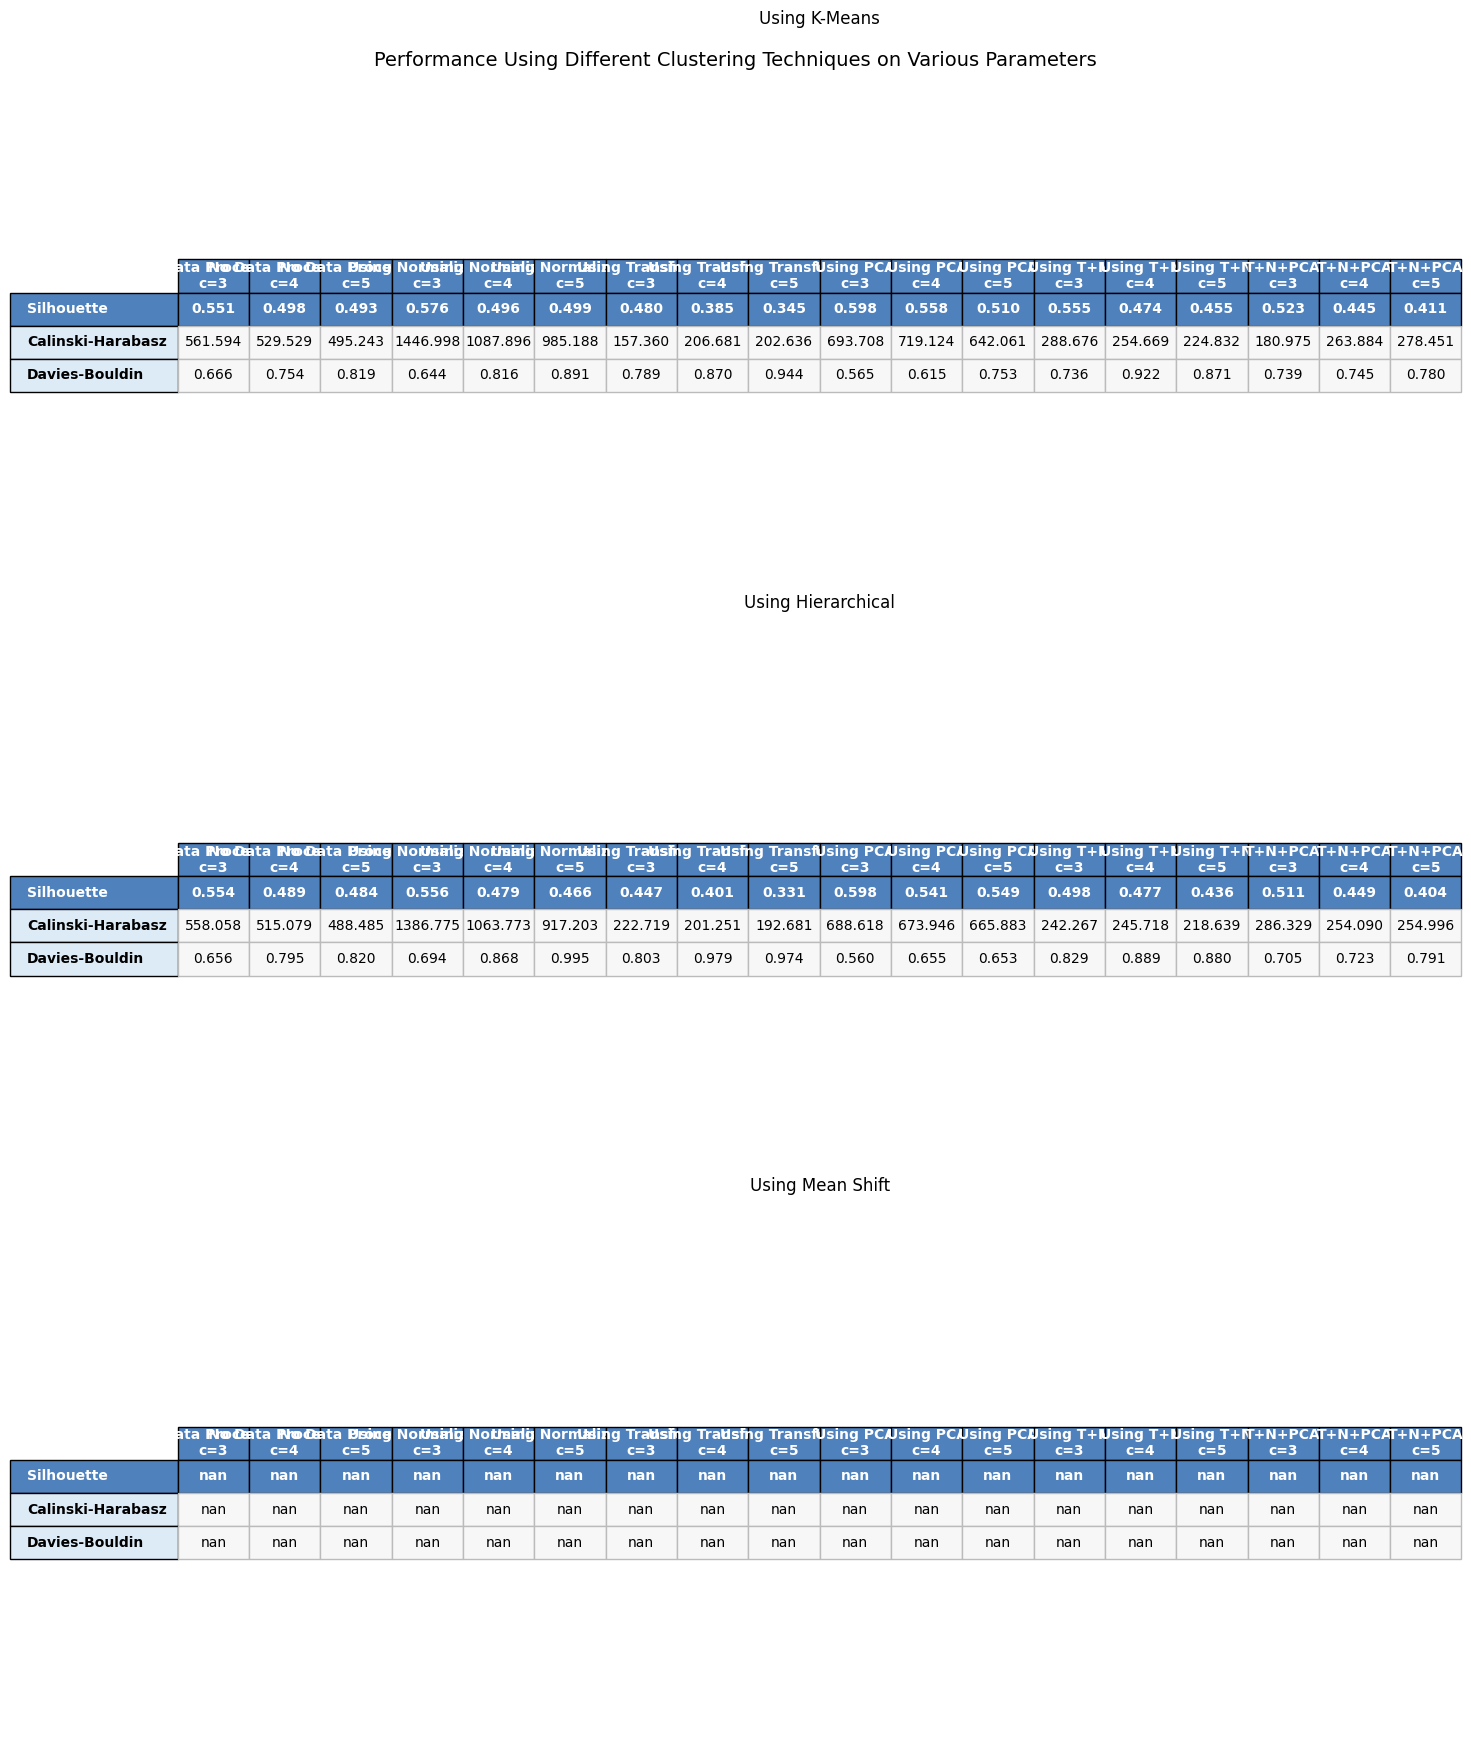

Analysis complete!


In [50]:
def main():
    """Main function to execute the clustering analysis pipeline."""
    try:
        # Load the Iris dataset
        print("Loading Iris dataset...")
        iris = load_iris()
        X = iris.data

        # Perform clustering analysis
        print("Performing clustering analysis...")
        results_df = perform_clustering_analysis(X)

        # Format the results
        print("Formatting results...")
        formatted_tables = format_results_table(results_df)

        # Save and visualize results with enhanced table styling
        print("Saving and visualizing results...")
        save_and_visualize_results(formatted_tables)

        print("Analysis complete!")

    except Exception as e:
        print(f"An error occurred during execution: {e}")

# Run the analysis
if __name__ == "__main__":
    main()